In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf
import os, json
from scipy import misc
import cv2
import pickle

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from cnn_builder import get_model

In [3]:
IMAGE_DATA_PATH = './data/simulator_data'

In [4]:
image_data = pd.read_csv(os.path.join(IMAGE_DATA_PATH, 'track_data.csv'))

In [5]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32021 entries, 0 to 32020
Data columns (total 7 columns):
center      32021 non-null object
left        32021 non-null object
right       32021 non-null object
steering    32021 non-null float64
throttle    32021 non-null float64
brake       32021 non-null float64
speed       32021 non-null float64
dtypes: float64(4), object(3)
memory usage: 1.7+ MB


In [6]:
image_data.head()

,center,left,right,steering,throttle,brake,speed
0,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19027
1,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19024
2,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19022
3,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19008
4,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.038627,1.0,0.0,30.19044


### Train-test split 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
ind_train, ind_test = train_test_split(np.array(range(len(image_data))), train_size=0.8, random_state = 42)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
train_df = image_data.loc[ind_train]
test_df = image_data.loc[ind_test]

### Make flipping

In [9]:
flipped_img_path = os.path.join( 'data/simulator_data/track/flip_init')

In [11]:
filenames = []
values = []
for i, row in train_df.iterrows():
    imgname = row['center']
    steering = row['steering']
    imgname = imgname.strip()
    img = cv2.imread(os.path.join(imgname))
    img = cv2.flip(img, flipCode=1)
    saving_name = os.path.join(flipped_img_path, os.path.split(imgname)[-1])
    cv2.imwrite(saving_name, img)
    filenames.append(saving_name)
    values.append(-1*steering)

In [12]:
flipped_df = pd.DataFrame({'center': filenames, 'steering': values})

In [13]:
flipped_init_df = pd.concat([train_df, flipped_df], ignore_index=True)

In [14]:
flipped_init_df.tail()

,brake,center,left,right,speed,steering,throttle
51227,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,-0.085837,NaN
51228,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,0.025751,NaN
51229,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,0.231760,NaN
51230,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,0.068670,NaN
51231,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,-0.060086,NaN


In [15]:
flipped_init_df.head()

,brake,center,left,right,speed,steering,throttle
0,0.0,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,20.94395,-0.240343,0.066289
1,0.0,data/simulator_data/track/run-5/IMG/center_201...,data/simulator_data/track/run-5/IMG/left_2018_...,data/simulator_data/track/run-5/IMG/right_2018...,21.90985,-0.326180,0.000000
2,0.0,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,30.19028,0.025751,1.000000
3,0.0,data/simulator_data/track/run-6/IMG/center_201...,data/simulator_data/track/run-6/IMG/left_2018_...,data/simulator_data/track/run-6/IMG/right_2018...,27.61868,0.154506,0.000000
4,0.0,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,27.81060,0.111588,0.000000


In [16]:
flipped_init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51232 entries, 0 to 51231
Data columns (total 7 columns):
brake       25616 non-null float64
center      51232 non-null object
left        25616 non-null object
right       25616 non-null object
speed       25616 non-null float64
steering    51232 non-null float64
throttle    25616 non-null float64
dtypes: float64(4), object(3)
memory usage: 2.7+ MB


### Training the models

In [17]:
def generator_df(samples_df_, source_path='data', data_columns = ['center'], val_column = 'steering', batch_size=4):
# yields batches from dataframe samples_df: ['images', 'steering']
    samples_df = samples_df_.copy()
    num_samples = len(samples_df)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples_df)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_df[offset:offset+batch_size]

            images = None
            angles = np.array([], dtype='float32')
            for i, batch_sample in batch_samples.iterrows():
                name = batch_sample[np.random.choice(data_columns, 1)].values[0]
                name = name.strip()
                center_image = cv2.imread(os.path.join(source_path,name))
                if center_image is not None:
                    center_angle = batch_sample[val_column]
                    if images is None:
                        images = center_image[np.newaxis]
                    else:
                        images = np.vstack([images, center_image[np.newaxis]])
                    angles = np.append(angles, center_angle)

            yield images, angles

In [18]:
def predict_generator_df(samples_df_, source_path='data', data_columns = ['center'], batch_size=4):
# yields batches for predictions, no shuffling
    samples_df = samples_df_.copy()
    num_samples = len(samples_df)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_df[offset:offset+batch_size]

            images = None
            angles = np.array([], dtype='float32')
            for i, batch_sample in batch_samples.iterrows():
                name = batch_sample[np.random.choice(data_columns, 1)].values[0]
                name = name.strip()
                center_image = cv2.imread(os.path.join(source_path,name))
                center_angle = batch_sample['steering']
                if images is None:
                    images = center_image[np.newaxis]
                else:
                    images = np.vstack([images, center_image[np.newaxis]])
                angles = np.append(angles, center_angle)

            yield images

In [24]:
BATCH_SIZE = 8
train_generator = generator_df(flipped_init_df, source_path='', batch_size=BATCH_SIZE)
val_generator = generator_df(test_df, source_path='', batch_size=BATCH_SIZE)

#### Training VGG16-based model

In [25]:
MODEL_SAVING_PATH = 'trained_weights/my_w/vgg16_center'
from keras.callbacks import ModelCheckpoint

In [26]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'weights_vgg16e_center.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [27]:
model_vgg16 = get_model('VGG16_e')
model_vgg16.compile(loss='mse', optimizer='adam')

In [29]:
history_vgg16 = model_vgg16.fit_generator(train_generator, steps_per_epoch=len(flipped_init_df)/BATCH_SIZE, validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0079 - val_loss: 0.0081

Epoch 00001: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.01-0.0081.hdf5
Epoch 2/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0082 - val_loss: 0.0062

Epoch 00002: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.02-0.0062.hdf5
Epoch 3/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0066 - val_loss: 0.0059

Epoch 00003: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.03-0.0059.hdf5
Epoch 4/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0058 - val_loss: 0.0057

Epoch 00004: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.04-0.0057.hdf5
Epoch 5/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0054 - val_loss: 0.0053

Epoch 00005: saving model to trained_weights/my_w/vgg16_center/weights

In [1]:
loss = [0.0081, 0.0062, 0.0059, 0.0057, 0.0053,0.0051,0.0050,0.0049,0.0048]

In [2]:
import matplotlib.pyplot as plt

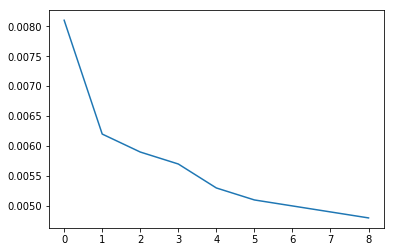

In [3]:
plt.plot(loss)